In [29]:
%load_ext autoreload
%autoreload

import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No module named 'catboost'
os.getcwd /home/ubuntu/proj/a_codetest


In [30]:
from utils import *

In [31]:
train_df = pd.read_csv('./data/address_matching_data.csv')
train_df.loc[train_df['is_match']==-1, 'is_match'] = 0
test_df = pd.read_csv('./data/address_matching_test.csv')
test_df['is_match'] = np.nan


In [33]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    categorical_columns = [col for col in df.columns]
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [34]:
### NA handling
df_ = train_df.append(test_df)
use_columns = [s for s in df_.columns if s not in ['id', 'is_match']]
df = df_[use_columns]

for c in df.columns:
    if df[c].dtype=='object':
        df.loc[df[c]=='?', c]=0
    else:
        print('skip ', c)


skip  name_levenshtein_simple
skip  name_trigram_simple
skip  name_levenshtein_term
skip  name_trigram_term


In [35]:
### Encode numerical into Category to handle NA distribution

labels = [1,2,3,4,5]
categories = ['phone_equality', 'fax_equality', 'street_number_equality']
for c in df.columns:
    if c in categories: continue
    df[c] = df[c].astype(np.float32)
    mi,ma = df[c].min(), df[c].max()
    space=(ma-mi)/5
    bins = [mi+i*space for  i in range(6)]
    bins[0]-=0.0000001
    df[c] = pd.cut(df[c], bins=bins, labels=labels)

    
    


In [37]:
df.head(5)
    




,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality
0,4,4,3,3,1,1,1,1,1,1,...,1,1,1,1,1,5,5,m,m,s
1,4,4,3,3,1,1,1,1,1,1,...,1,1,1,1,1,5,5,m,m,s
2,5,5,5,5,5,5,5,5,5,5,...,1,5,5,1,1,5,5,s,m,s
3,3,2,2,1,1,1,1,1,1,1,...,1,5,5,1,1,1,1,s,m,n
4,4,4,3,3,5,5,5,5,5,5,...,1,5,5,1,1,5,5,s,m,s


In [38]:
# categories = ['phone_equality', 'fax_equality', 'street_number_equality']
# for c in df.columns:
#     if c in categories: continue
#     df[c] = df[c].astype(np.float32)
    
df, cols = one_hot_encoder(df, nan_as_category=False)



In [39]:
### Merge back
df['is_match'] = df_['is_match']



0

In [40]:
#### Train
train_df = df[df['is_match'].notnull()]

#### Null is Test
test_df = df[df['is_match'].isnull()]

FEATS_EXCLUDED = ['is_match']
feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]



In [41]:
#### Train Split
X = train_df[feats].values
yy = train_df['is_match'].values

### High test % to reduce overfitting
X_train, X_test, y_train, y_test = train_test_split( X, yy, test_size=0.8, 
                                                     random_state=42)




Test confusion matrix
[[ 5890   499]
 [ 1171 15028]]
[[0.92189701 0.07810299]
 [0.07228841 0.92771159]]
auc 0.9792350889838005
gini 0.958470177967601
acc 0.9260669381972729
f1macro 0.9115991082566408
Nsample 22588
             precision    recall  f1-score   support

          0       0.83      0.92      0.88      6389
          1       0.97      0.93      0.95     16199

avg / total       0.93      0.93      0.93     22588



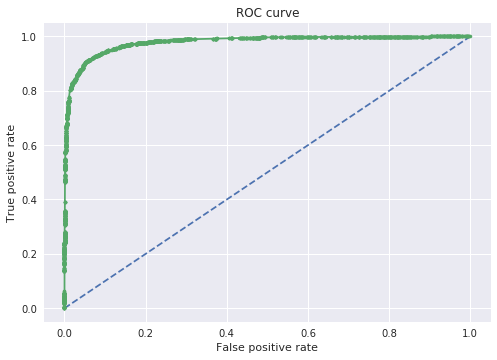

In [42]:
### L1 penalty to reduce overfitting
clf = sk.linear_model.LogisticRegression(penalty = 'l1' , class_weight = 'balanced')

clf.fit(X_train, y_train)
ytest_proba   = clf.predict_proba(X_test)[:, 1]
ytest_pred    = clf.predict(X_test)
sk_showmetrics(y_test, ytest_pred, ytest_proba)




In [ ]:
"""
Sparse Logistics


"""

In [45]:
df_featlogis = feature_impt_logis(clf, feats)
df_featlogis


,coef,coef_abs,feature,rank
21,-3.370079,3.370079,city_levenshtein_simple_2,0
15,-2.696743,2.696743,name_trigram_term_1,1
138,2.417505,2.417505,street_number_equality_s,2
5,-2.196318,2.196318,name_trigram_simple_1,3
9,2.045291,2.045291,name_trigram_simple_5,4
104,1.964715,1.964715,phone_levenshtein_5,5
56,-1.773089,1.773089,zip_trigram_term_2,6
92,-1.449794,1.449794,website_levenshtein_term_3,7
131,-1.439839,1.439839,phone_equality_n,8
84,1.343591,1.343591,website_levenshtein_simple_5,9


In [46]:
### NO Null Features
len(df_featlogis[df_featlogis["coef_abs"] > 0.0 ])

69

In [ ]:

preds = clf.predict(test_df[feats])
preds[preds==0] = -1


In [ ]:
test_df = pd.read_csv('./data/address_matching_test.csv')
test_df['is_match'] = preds.astype(int)
test_df = test_df.reset_index()
test_df[['id', 'is_match']].to_csv('result.csv', index=False)


